In [1]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Вкажіть шлях до вашого ZIP-файлу
zip_file_path = 'C:/Users/MikeK/GoIT/homework.zip'
extract_path = 'C:/Users/MikeK/GoIT/homework'

# Розпакування ZIP-файлу
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

def extract_features_from_segment(segment):
    features = {
        'mean_X': segment['accelerometer_X'].mean(),
        'mean_Y': segment['accelerometer_Y'].mean(),
        'mean_Z': segment['accelerometer_Z'].mean(),
        'std_X': segment['accelerometer_X'].std(),
        'std_Y': segment['accelerometer_Y'].std(),
        'std_Z': segment['accelerometer_Z'].std(),
        'max_X': segment['accelerometer_X'].max(),
        'max_Y': segment['accelerometer_Y'].max(),
        'max_Z': segment['accelerometer_Z'].max(),
        'min_X': segment['accelerometer_X'].min(),
        'min_Y': segment['accelerometer_Y'].min(),
        'min_Z': segment['accelerometer_Z'].min(),
        'energy_X': np.sum(segment['accelerometer_X'] ** 2) / len(segment),
        'energy_Y': np.sum(segment['accelerometer_Y'] ** 2) / len(segment),
        'energy_Z': np.sum(segment['accelerometer_Z'] ** 2) / len(segment)
    }
    return pd.Series(features)

In [2]:
base_path = 'C:/Users/MikeK/GoIT/homework/data'
activities = ['idle', 'running', 'stairs', 'walking']

data = []
activity_id = 0  # Ідентифікатор активності

# Ітеруємося по кожній папці та зчитуємо файли
for activity in activities:
    folder_path = os.path.join(base_path, activity)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if file.endswith('.csv'):
            df = pd.read_csv(file_path)
            df['Activity'] = activity
            df['Activity_ID'] = activity_id  # Додавання стовпця з номером активності
            data.append(df)  # Додавання до загального списку
            activity_id += 1  # Збільшення номера активності для наступного файлу

# Об'єднання всіх даних в один датасет
combined_data = pd.concat(data, ignore_index=True)

# Перевірка перших рядків об'єднаного датасету
print(combined_data.head())


   accelerometer_X  accelerometer_Y  accelerometer_Z Activity  Activity_ID
0         1.000776         4.616021         8.576031     idle            0
1         0.718261         4.209007         8.446744     idle            0
2        -0.909797        -0.282516         9.203311     idle            0
3         5.099650         0.148441         8.418014     idle            0
4         1.762132        -0.162806         9.251195     idle            0


In [3]:
print(combined_data)

        accelerometer_X  accelerometer_Y  accelerometer_Z Activity  \
0              1.000776         4.616021         8.576031     idle   
1              0.718261         4.209007         8.446744     idle   
2             -0.909797        -0.282516         9.203311     idle   
3              5.099650         0.148441         8.418014     idle   
4              1.762132        -0.162806         9.251195     idle   
...                 ...              ...              ...      ...   
193855         5.109226       -15.452178        -1.470040  walking   
193856         6.373365       -11.741165        -8.226476  walking   
193857         3.289633        -9.993398        -0.383072  walking   
193858        -2.978387        -3.050213         1.273715  walking   
193859        -4.347870        -9.926360        -1.642422  walking   

        Activity_ID  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
19385

In [4]:
# Перевірка на відсутні значення
print(df.isnull().sum())

accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
Activity           0
Activity_ID        0
dtype: int64


In [5]:
# Обчислення ознак для кожного файлу окремо
features_data = combined_data.groupby(['Activity', 'Activity_ID']).apply(extract_features_from_segment, include_groups=False).reset_index()

# Нормалізація даних
scaler = StandardScaler()
X = scaler.fit_transform(features_data.drop(['Activity', 'Activity_ID'], axis=1))
y = features_data['Activity']

# Розділення на тренувальну і тестову вибірку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Розмір тренувальної вибірки:", X_train.shape)
print("Розмір тестової вибірки:", X_test.shape)


Розмір тренувальної вибірки: (5169, 15)
Розмір тестової вибірки: (1293, 15)


In [6]:
# Створення моделей
svm_model = SVC(kernel='linear', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Навчання моделей
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Прогнози на тестових даних
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Оцінка моделей
print("SVM Model Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Random Forest Model Classification Report:")
print(classification_report(y_test, y_pred_rf))

SVM Model Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       220
     running       1.00      1.00      1.00       689
      stairs       0.75      0.70      0.72        30
     walking       0.97      0.98      0.98       354

    accuracy                           0.99      1293
   macro avg       0.93      0.92      0.93      1293
weighted avg       0.99      0.99      0.99      1293

Random Forest Model Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       220
     running       1.00      1.00      1.00       689
      stairs       1.00      0.97      0.98        30
     walking       1.00      1.00      1.00       354

    accuracy                           1.00      1293
   macro avg       1.00      0.99      1.00      1293
weighted avg       1.00      1.00      1.00      1293



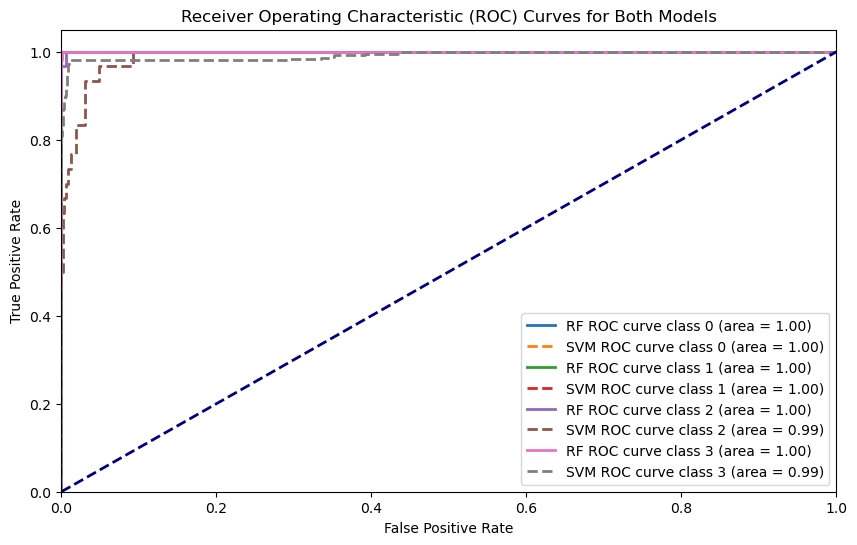

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Бінаризація міток класів для багатокласової класифікації
y_test_binarized = label_binarize(y_test, classes=['idle', 'running', 'stairs', 'walking'])
n_classes = y_test_binarized.shape[1]

# Прогнози для кожного класу для обох моделей
y_probs_rf = rf_model.predict_proba(X_test)
y_probs_svm = svm_model.decision_function(X_test)

# Створення ROC-кривих для кожної моделі та кожного класу
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_probs_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_binarized[:, i], y_probs_svm[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Побудова графіків
plt.figure(figsize=(10, 6))

for i in range(n_classes):
    # Графік для Random Forest
    plt.plot(fpr_rf[i], tpr_rf[i], lw=2, linestyle='-', label='RF ROC curve class {0} (area = {1:0.2f})'
                                                             ''.format(i, roc_auc_rf[i]))
    
    # Графік для SVM
    plt.plot(fpr_svm[i], tpr_svm[i], lw=2, linestyle='--', label='SVM ROC curve class {0} (area = {1:0.2f})'
                                                               ''.format(i, roc_auc_svm[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Both Models')
plt.legend(loc="lower right")
plt.show()

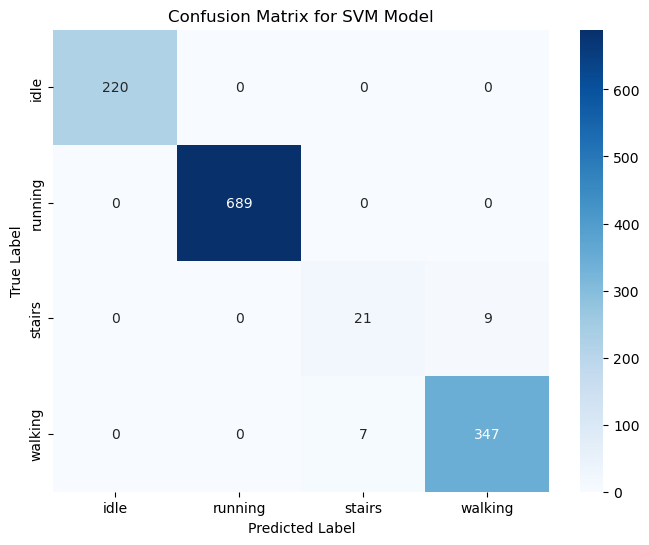

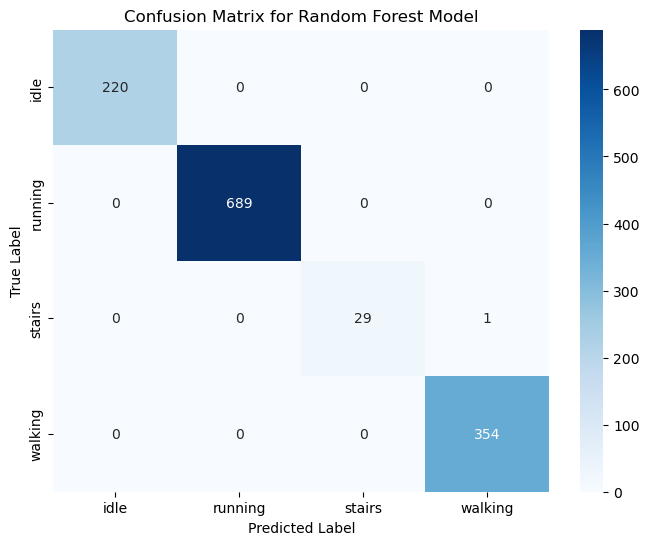

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Обчислення Confusion Matrix для SVM
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)

# Обчислення Confusion Matrix для Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)

# Візуалізація Confusion Matrix для SVM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Візуалізація Confusion Matrix для Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
1. Precision (Точність):Модель Random Forest має вищу точність для класу stairs (1.00 проти 0.75 у SVM), а також вищу загальну макро- та зважену середню точність. Це означає, що Random Forest краще відрізняє кожен клас від інших, особливо для класу stairs.
2. Recall (Відклик):Модель Random Forest знову показує кращі результати, особливо для класу stairs (0.97 проти 0.70 у SVM). Вища макро- та зважена середня відклик вказує на те, що модель Random Forest краще ідентифікує всі наявні випадки кожного класу.
3. F1-Score:Random Forest має кращий F1-Score для класу stairs (0.98 проти 0.72 у SVM), а також вищі макро- та зважені середні значення. Це вказує на те, що Random Forest модель є кращою в балансуванні між точністю і відкликом.
4. Accuracy (Точність класифікації):Random Forest модель має трохи вищу загальну точність (1.00 проти 0.99 у SVM).
5. Macro Average (Середнє арифметичне):Random Forest показує вищі macro avg значення для всіх метрик:
precision — 1.00 проти 0.93 у SVM, що означає, що модель Random Forest має вищу середню точність по всіх класах.
recall — 0.99 проти 0.92 у SVM, що показує кращу здатність Random Forest знаходити всі позитивні випадки для всіх класів.
f1-score — 1.00 проти 0.93 у SVM, що вказує на краще балансування між точністю і відкликом для кожного класу.
Це свідчить про те, що модель Random Forest забезпечує високу продуктивність для всіх класів, тоді як SVM має деякі труднощі з класифікацією класу stairs.
6. Weighted Average (Зважене середнє):Random Forest має вищі weighted avg значення для всіх метрик:
precision — 1.00 проти 0.99 у SVM, що означає, що Random Forest більш точна в класифікації всіх класів з урахуванням їхньої частоти.
recall — 1.00 проти 0.99 у SVM, що показує, що Random Forest краще виявляє всі позитивні випадки для кожного класу.
f1-score — 1.00 проти 0.99 у SVM, що означає, що Random Forest краще балансує між точністю та відкликом для всіх класів.
Таким чином, зважене середнє також вказує на те, що Random Forest модель краще класифікує всі класи, враховуючи їхню частоту, на відміну від SVM, яка має трохи нижчі значення для всіх метрик.
7. Confusion Matrix: Модель SVM добре працює для основних класів ('idle' і 'running'), але має труднощі з відокремленням класів 'stairs' і 'walking'.
Модель Random Forest демонструє високу ефективність у всіх класах, зокрема, для класу 'stairs', де вона суттєво перевершує SVM.
8. ROC-криві: Криві Random Forest (RF) та SVM:
Клас 0 ("idle") і Клас 1 ("running"): Обидві моделі (RF і SVM) показують ідеальний результат з AUC = 1.0. Це означає, що моделі ідеально розрізняють ці класи без жодних помилок.
Клас 2 ("stairs") і Клас 3 ("walking"): AUC для класів 2 і 3 для обох моделей близько 0.99. Це означає, що і RF, і SVM моделі добре справляються з розпізнаванням цих класів, але SVM має трохи менше значення AUC, що вказує на незначні помилки.
Загальні висновки з ROC-кривих:
Random Forest модель (RF) має трохи кращу продуктивність, оскільки її AUC для всіх класів становить 1.0. Це вказує на те, що RF модель краще розрізняє всі чотири класи.
SVM модель теж показує хороші результати, але має трохи менше AUC для класів 2 і 3, що вказує на незначні помилки в класифікації цих класів.
Що це означає для моделі:
Random Forest є дуже надійною для цього набору даних, оскільки вона демонструє максимальну ефективність для всіх класів.
SVM також працює добре, але є кілька незначних випадків, де вона не настільки точна, як Random Forest.

SyntaxError: invalid character '—' (U+2014) (1303488915.py, line 6)